# **Project Topic**

> Pavankumar Mahadik (Red ID : **824637106**)


## **Import Modules**

In [0]:
import numpy as np
import json,sys
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score, plot_confusion_matrix
#from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from PIL import Image, ImageDraw 

## **Dataset**

**We uploaded dataset on google drive because it is easy to mount drive with google colab and work. If you want to run in jupyter notbook then don't run this cell.**

In [0]:
#drive.mount('/content/gdrive')
#%cd ./gdrive/My Drive/ACV

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/ACV


**Load the data and see check how an image looks like**

In [0]:
f = open(r'shipsnet.json')
dataset = json.load(f)
f.close()

In [0]:
dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

**Reshape the image so that we can visualize.**

(4000, 80, 80, 3)


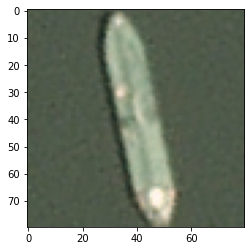

In [0]:
data = np.array(dataset['data']).astype('uint8')
img_length = 80
data = data.reshape(-1,3,img_length,img_length).transpose([0,2,3,1])
print(data.shape)
plt.imshow(data[51])

## **Data Preprocessing**

**Convert the images to grayscale colorspace before calculating the HOG features for each image**

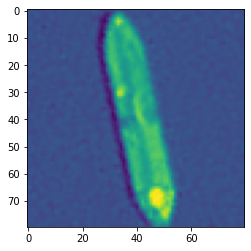

In [0]:
data_gray = [ color.rgb2gray(i) for i in data]
plt.imshow(data_gray[51])

**The hog function of skimage returns a matrix that can be used to visualize the gradients**

In [0]:
ppc = 16
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

**Plot the image to visualize hog features.**

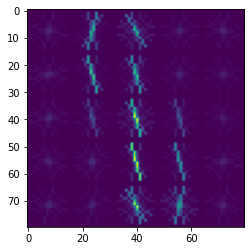

In [0]:
plt.imshow(hog_images[51])

**Convert input features and output labels into nparray to train SVM.**

In [0]:
hog_features = np.array(hog_features)

In [0]:
labels =  np.array(dataset['labels']).reshape(len(dataset['labels']),1)

**Shuffle indexes for better result.**

In [0]:
np.random.seed(42)

In [0]:
index = np.arange(4000)
np.random.shuffle(index)

In [0]:
X = hog_features[index]
y = labels[index]

**What percentage of data you want to keep for testing**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## **Support Vector Machine (SVM)**

**Fit a simple SVM classifier to the data.**

In [0]:
clf = svm.SVC(kernel='linear')

In [0]:
clf.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Let's do prediction and find accuracy score.**

In [0]:
y_pred= clf.predict(X_test)

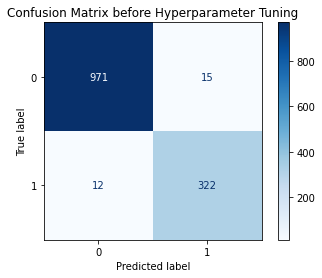

In [0]:
disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, values_format = '.4g')
disp.ax_.set_title("Confusion Matrix before Hyperparameter Tuning")
plt.show()

In [0]:
print("Before Hyperparameter Tuning\n\n")
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Before Hyperparameter Tuning


Accuracy: 0.9795454545454545


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       986
           1       0.96      0.96      0.96       334

    accuracy                           0.98      1320
   macro avg       0.97      0.97      0.97      1320
weighted avg       0.98      0.98      0.98      1320



## **Testing**

**Get satellite image for testing.**

In [0]:
testImage = Image.open('scenes/sfbay_1.png')
p = testImage.load()

In [0]:
spectrum = 3
width = testImage.size[0]
height = testImage.size[1]

In [0]:
picVector = []
for channel in range(spectrum):
    for y in range(height):
        for x in range(width):
            picVector.append(p[x, y][channel])

In [0]:
picVector = np.array(picVector).astype('uint8')
picTensor = picVector.reshape([spectrum, height, width]).transpose(1,2,0)

In [0]:
picTensor.shape

(1777, 2825, 3)

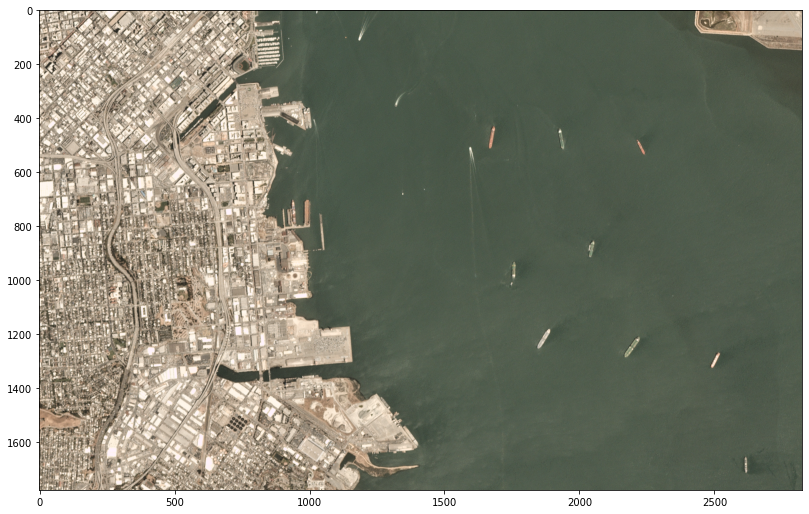

In [0]:
plt.figure(1, figsize=(15,30))
plt.subplot(3,1,1)
plt.imshow(picTensor)
plt.show()

In [0]:
picTensor = picTensor.transpose(2,0,1)

In [0]:
picTensor.shape

(3, 1777, 2825)

**Search on the image.**

In [0]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picTensor[0][y+i][x+j]
            area_study[1][i][j] = picTensor[1][y+i][x+j]
            area_study[2][i][j] = picTensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [0]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [0]:
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picTensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picTensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picTensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picTensor[ch][y+th+80][x+i] = -1

X:850 Y:0  [1]


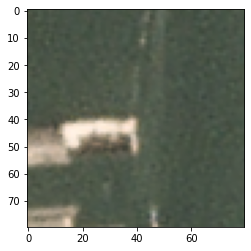

X:2410 Y:20  [1]


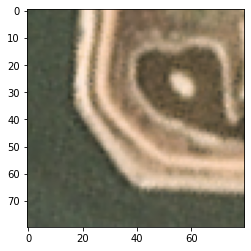

X:1160 Y:40  [1]


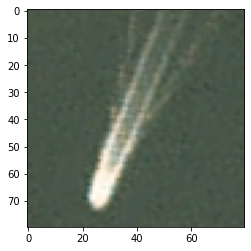

X:2580 Y:50  [1]


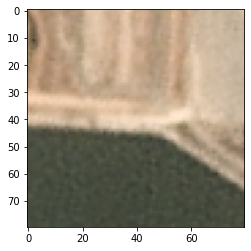

X:510 Y:120  [1]


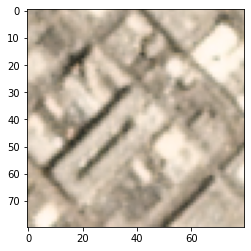

X:630 Y:230  [1]


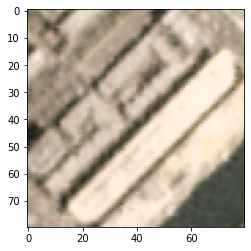

X:770 Y:230  [1]


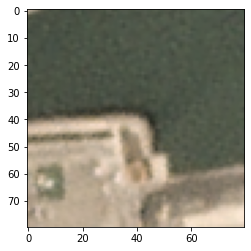

X:1290 Y:290  [1]


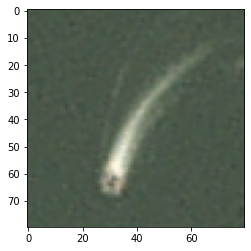

X:130 Y:320  [1]


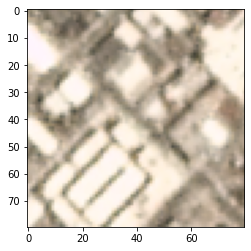

X:880 Y:360  [1]


X:1890 Y:420  [1]


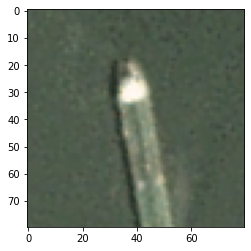

X:2180 Y:460  [1]


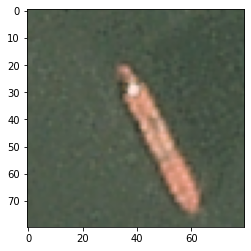

X:880 Y:470  [1]


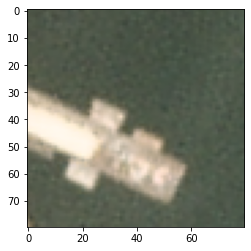

X:380 Y:480  [1]


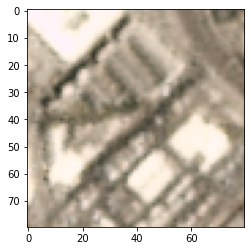

X:1560 Y:490  [1]


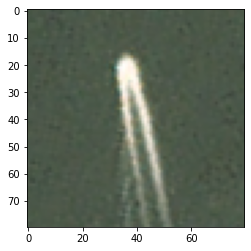

X:620 Y:530  [1]


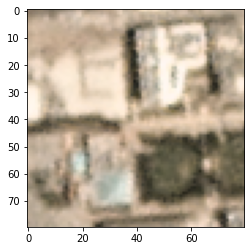

X:180 Y:590  [1]


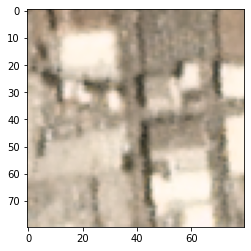

X:790 Y:640  [1]


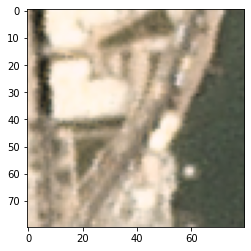

X:900 Y:680  [1]


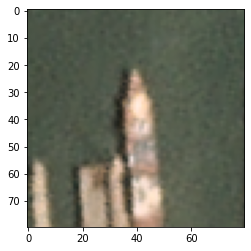

X:800 Y:740  [1]


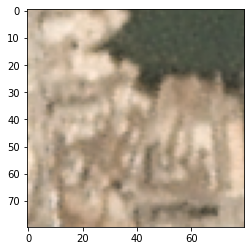

X:2010 Y:820  [1]


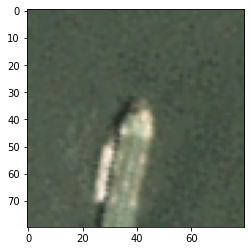

X:950 Y:920  [1]


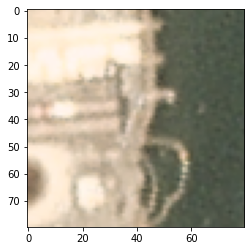

X:1710 Y:920  [1]


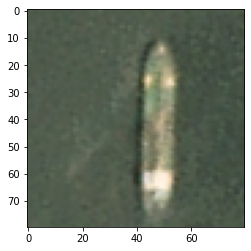

X:960 Y:1110  [1]


X:1830 Y:1170  [1]


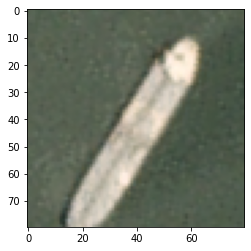

X:2150 Y:1200  [1]


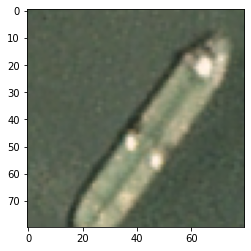

X:830 Y:1240  [1]


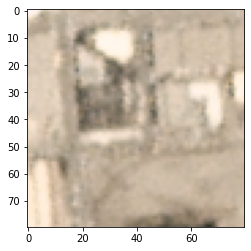

X:2460 Y:1250  [1]


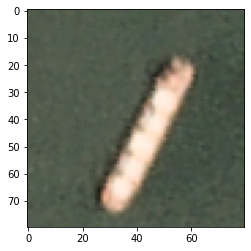

X:1090 Y:1260  [1]


X:420 Y:1270  [1]


X:980 Y:1270  [1]


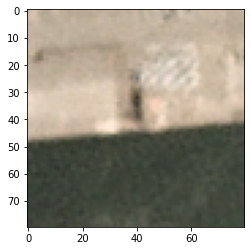

X:720 Y:1300  [1]


X:1270 Y:1460  [1]


X:1250 Y:1590  [1]


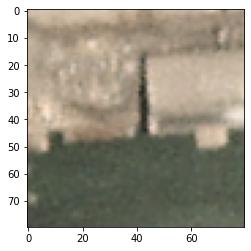

X:1100 Y:1600  [1]


X:2570 Y:1640  [1]


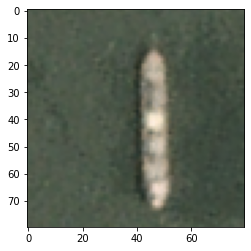

X:1340 Y:1650  [1]


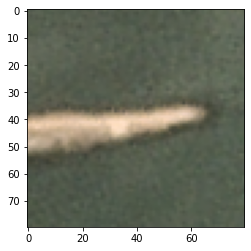

X:2740 Y:1690  

In [0]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        data_gray = [ color.rgb2gray(i) for i in area]
        hog_feat = []
        for image in data_gray:
          fd,hog_image = hog(image, orientations=8, pixels_per_cell=(16,16),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
          hog_feat.append(fd)
        hog_feat = np.array(hog_feat)
        result = clf.predict(hog_feat)
        if result[0] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [0]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0])

In [0]:
picTensor = picTensor.transpose(1,2,0)
picTensor.shape

(1777, 2825, 3)

In [0]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picTensor)

plt.show()

## **Hyperparameter Tuning using GridSearchCV**

**I did Hyperparameter tuning using GridSearchCV by taking below parameters.**
*   **C = [0.1, 1, 5, 10, 50, 100]**
*   **gamma = ['scale', 'auto']**
*   **kernel = ['rbf', 'poly', 'sigmoid']**

In [0]:
C = [0.1, 1, 5, 10, 50, 100]
gamma = ['scale', 'auto']
kernel = ['rbf', 'poly', 'sigmoid']
param_grid = dict(C=C, gamma=gamma, kernel=kernel)
grid = GridSearchCV(svm.SVC(),param_grid = param_grid,verbose=2, cv = 2)
grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] C=0.1, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=scale, kernel=poly .................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=0.1, gamma=scale, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=scale, kernel=poly .................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=0.1, gamma=scale, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=scale, kernel=sigmoid ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.1, gamma=scale, kernel=sigmoid, total=   1.3s
[CV] C=0.1, gamma=scale, kernel=sigmoid ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.1, gamma=scale, kernel=sigmoid, total=   1.3s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=0.1, gamma=auto, kernel=rbf, total=   1.3s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=0.1, gamma=auto, kernel=rbf, total=   1.2s
[CV] C=0.1, gamma=auto, kernel=poly ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=auto, kernel=poly, total=   1.2s
[CV] C=0.1, gamma=auto, kernel=poly ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=auto, kernel=poly, total=   1.2s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.1, gamma=auto, kernel=sigmoid, total=   1.2s
[CV] C=0.1, gamma=auto, kernel=sigmoid ...............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.1, gamma=auto, kernel=sigmoid, total=   1.2s
[CV] C=1, gamma=scale, kernel=rbf ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=scale, kernel=rbf, total=   0.6s
[CV] C=1, gamma=scale, kernel=rbf ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=scale, kernel=rbf, total=   0.6s
[CV] C=1, gamma=scale, kernel=poly ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=1, gamma=scale, kernel=poly, total=   0.4s
[CV] C=1, gamma=scale, kernel=poly ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=1, gamma=scale, kernel=poly, total=   0.4s
[CV] C=1, gamma=scale, kernel=sigmoid ................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=1, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=1, gamma=scale, kernel=sigmoid ................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=1, gamma=scale, kernel=sigmoid, total=   1.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=1, gamma=auto, kernel=rbf, total=   1.3s
[CV] C=1, gamma=auto, kernel=rbf .....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=1, gamma=auto, kernel=rbf, total=   1.3s
[CV] C=1, gamma=auto, kernel=poly ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=auto, kernel=poly, total=   1.2s
[CV] C=1, gamma=auto, kernel=poly ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=auto, kernel=poly, total=   1.2s
[CV] C=1, gamma=auto, kernel=sigmoid .................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1, gamma=auto, kernel=sigmoid, total=   1.3s
[CV] C=1, gamma=auto, kernel=sigmoid .................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1, gamma=auto, kernel=sigmoid, total=   1.3s
[CV] C=5, gamma=scale, kernel=rbf ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=5, gamma=scale, kernel=rbf, total=   0.5s
[CV] C=5, gamma=scale, kernel=rbf ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=5, gamma=scale, kernel=rbf, total=   0.6s
[CV] C=5, gamma=scale, kernel=poly ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=5, gamma=scale, kernel=poly, total=   0.4s
[CV] C=5, gamma=scale, kernel=poly ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=5, gamma=scale, kernel=poly, total=   0.4s
[CV] C=5, gamma=scale, kernel=sigmoid ................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=5, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=5, gamma=scale, kernel=sigmoid ................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=5, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=5, gamma=auto, kernel=rbf .....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=5, gamma=auto, kernel=rbf, total=   1.0s
[CV] C=5, gamma=auto, kernel=rbf .....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=5, gamma=auto, kernel=rbf, total=   1.1s
[CV] C=5, gamma=auto, kernel=poly ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=5, gamma=auto, kernel=poly, total=   1.2s
[CV] C=5, gamma=auto, kernel=poly ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=5, gamma=auto, kernel=poly, total=   1.2s
[CV] C=5, gamma=auto, kernel=sigmoid .................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=5, gamma=auto, kernel=sigmoid, total=   1.2s
[CV] C=5, gamma=auto, kernel=sigmoid .................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=5, gamma=auto, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=scale, kernel=rbf ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=scale, kernel=rbf, total=   0.5s
[CV] C=10, gamma=scale, kernel=rbf ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=scale, kernel=rbf, total=   0.5s
[CV] C=10, gamma=scale, kernel=poly ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=10, gamma=scale, kernel=poly, total=   0.4s
[CV] C=10, gamma=scale, kernel=poly ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=10, gamma=scale, kernel=poly, total=   0.4s
[CV] C=10, gamma=scale, kernel=sigmoid ...............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=10, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=10, gamma=scale, kernel=sigmoid ...............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=10, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=10, gamma=auto, kernel=rbf ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=10, gamma=auto, kernel=rbf, total=   0.9s
[CV] C=10, gamma=auto, kernel=rbf ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=10, gamma=auto, kernel=rbf, total=   0.9s
[CV] C=10, gamma=auto, kernel=poly ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=auto, kernel=poly, total=   1.2s
[CV] C=10, gamma=auto, kernel=poly ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=auto, kernel=poly, total=   1.2s
[CV] C=10, gamma=auto, kernel=sigmoid ................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=10, gamma=auto, kernel=sigmoid, total=   1.0s
[CV] C=10, gamma=auto, kernel=sigmoid ................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=10, gamma=auto, kernel=sigmoid, total=   1.0s
[CV] C=50, gamma=scale, kernel=rbf ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=50, gamma=scale, kernel=rbf, total=   0.5s
[CV] C=50, gamma=scale, kernel=rbf ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=50, gamma=scale, kernel=rbf, total=   0.5s
[CV] C=50, gamma=scale, kernel=poly ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=50, gamma=scale, kernel=poly, total=   0.4s
[CV] C=50, gamma=scale, kernel=poly ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=50, gamma=scale, kernel=poly, total=   0.4s
[CV] C=50, gamma=scale, kernel=sigmoid ...............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=50, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=50, gamma=scale, kernel=sigmoid ...............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=50, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=50, gamma=auto, kernel=rbf ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=50, gamma=auto, kernel=rbf, total=   0.6s
[CV] C=50, gamma=auto, kernel=rbf ....................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=50, gamma=auto, kernel=rbf, total=   0.7s
[CV] C=50, gamma=auto, kernel=poly ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=50, gamma=auto, kernel=poly, total=   1.2s
[CV] C=50, gamma=auto, kernel=poly ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=50, gamma=auto, kernel=poly, total=   1.2s
[CV] C=50, gamma=auto, kernel=sigmoid ................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=50, gamma=auto, kernel=sigmoid, total=   0.7s
[CV] C=50, gamma=auto, kernel=sigmoid ................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=50, gamma=auto, kernel=sigmoid, total=   0.7s
[CV] C=100, gamma=scale, kernel=rbf ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=scale, kernel=rbf, total=   0.5s
[CV] C=100, gamma=scale, kernel=rbf ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=scale, kernel=rbf, total=   0.5s
[CV] C=100, gamma=scale, kernel=poly .................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=100, gamma=scale, kernel=poly, total=   0.4s
[CV] C=100, gamma=scale, kernel=poly .................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=100, gamma=scale, kernel=poly, total=   0.4s
[CV] C=100, gamma=scale, kernel=sigmoid ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=100, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=scale, kernel=sigmoid ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=100, gamma=scale, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=auto, kernel=rbf ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=100, gamma=auto, kernel=rbf, total=   0.5s
[CV] C=100, gamma=auto, kernel=rbf ...................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=100, gamma=auto, kernel=rbf, total=   0.6s
[CV] C=100, gamma=auto, kernel=poly ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=auto, kernel=poly, total=   1.2s
[CV] C=100, gamma=auto, kernel=poly ..................................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=auto, kernel=poly, total=   1.2s
[CV] C=100, gamma=auto, kernel=sigmoid ...............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=100, gamma=auto, kernel=sigmoid, total=   0.6s
[CV] C=100, gamma=auto, kernel=sigmoid ...............................


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=100, gamma=auto, kernel=sigmoid, total=   0.7s


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Get the best parameter and best score.**

In [0]:
print("Best: %f using \n%s" % (grid_result.best_score_, grid_result.best_params_))
print("\n\n")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.992164 using 
{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}



0.929851 (0.000746) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.988433 (0.003358) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.883209 (0.002612) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.751493 (0.000000) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.751493 (0.000000) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
0.751493 (0.000000) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.991791 (0.001493) with: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.990299 (0.000746) with: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
0.770522 (0.004851) with: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.763433 (0.008209) with: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.751493 (0.000000) with: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
0.751493 (0.000000) with: {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.992164 (0.001866) with: {'C': 5, 'gamma': 'scale', 'kernel': 'r

In [0]:
y_pred_hyper= grid_result.best_estimator_.predict(X_test)
disp = plot_confusion_matrix(grid_result.best_estimator_, X_test, y_test, cmap=plt.cm.Blues, values_format = '.4g')
disp.ax_.set_title("Confusion Matrix after Hyperparameter Tuning")
plt.show()

In [0]:
print("After Hyperparameter Tuning\n\n")
print("Accuracy: "+str(accuracy_score(y_test, y_pred_hyper)))
print('\n')
print(classification_report(y_test, y_pred_hyper))

After Hyperparameter Tuning


Accuracy: 0.9946969696969697


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       986
           1       0.99      0.99      0.99       334

    accuracy                           0.99      1320
   macro avg       0.99      0.99      0.99      1320
weighted avg       0.99      0.99      0.99      1320



**Testing**

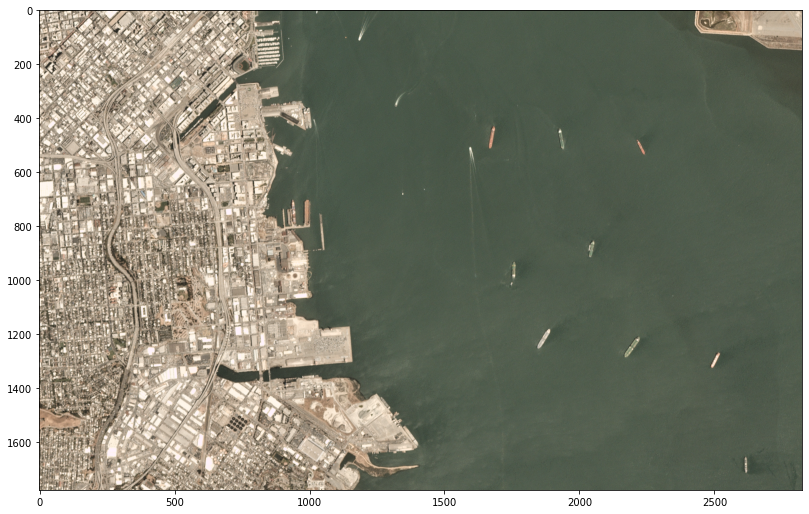

(3, 1777, 2825)

In [0]:
testImage = Image.open('scenes/sfbay_1.png')
p = testImage.load()
spectrum = 3
width = testImage.size[0]
height = testImage.size[1]
picVector = []
for channel in range(spectrum):
    for y in range(height):
        for x in range(width):
            picVector.append(p[x, y][channel])
picVector = np.array(picVector).astype('uint8')
picTensor = picVector.reshape([spectrum, height, width]).transpose(1,2,0)
plt.figure(1, figsize=(15,30))
plt.subplot(3,1,1)
plt.imshow(picTensor)
plt.show()
picTensor = picTensor.transpose(2,0,1)
picTensor.shape

X:810 Y:10  [1]


X:1160 Y:40  [1]


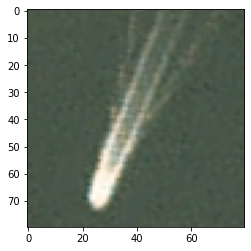

X:2440 Y:40  [1]


X:2530 Y:50  [1]


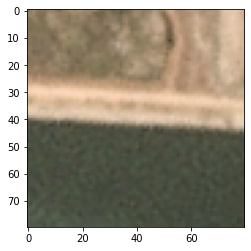

X:2620 Y:70  [1]


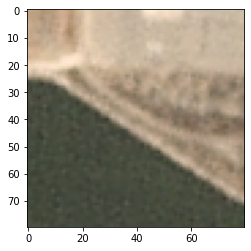

X:2710 Y:100  [1]


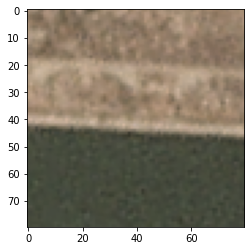

X:740 Y:230  [1]


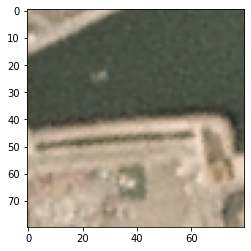

X:820 Y:350  [1]


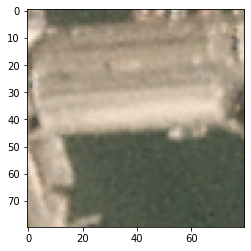

X:1640 Y:430  [1]


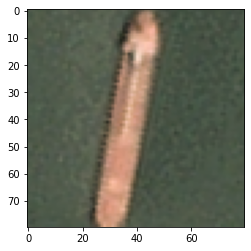

X:1890 Y:430  [1]


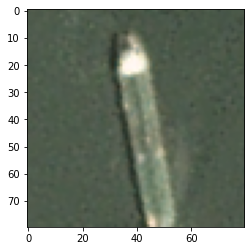

X:2190 Y:470  [1]


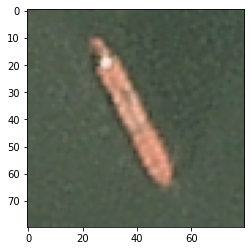

X:2000 Y:850  [1]


X:1720 Y:920  [1]


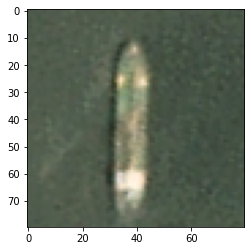

X:930 Y:1030  [1]


X:1070 Y:1130  [1]


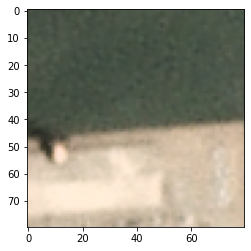

X:1830 Y:1170  [1]


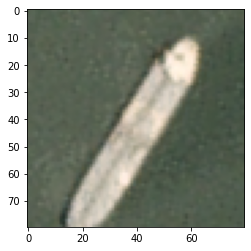

X:2160 Y:1200  [1]


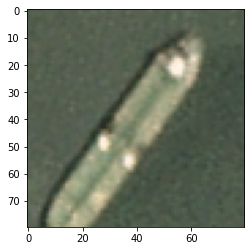

X:2470 Y:1250  [1]


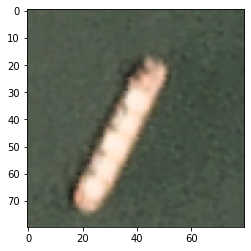

X:1070 Y:1260  [1]


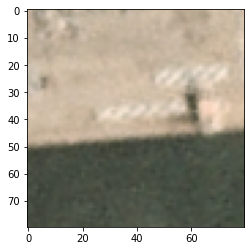

X:950 Y:1270  [1]


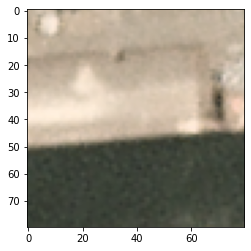

X:710 Y:1340  [1]


X:1240 Y:1410  [1]


X:1330 Y:1530  [1]


X:2580 Y:1640  [1]


X:1220 Y:1650  [1]


X:1310 Y:1650  [1]


X:2740 Y:1690  

In [0]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        data_gray = [ color.rgb2gray(i) for i in area]
        hog_feat = []
        for image in data_gray:
          fd,hog_image = hog(image, orientations=8, pixels_per_cell=(16,16),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
          hog_feat.append(fd)
        hog_feat = np.array(hog_feat)
        result = grid_result.best_estimator_.predict(hog_feat)
        if result[0] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [0]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0])

In [0]:
picTensor = picTensor.transpose(1,2,0)
picTensor.shape

(1777, 2825, 3)

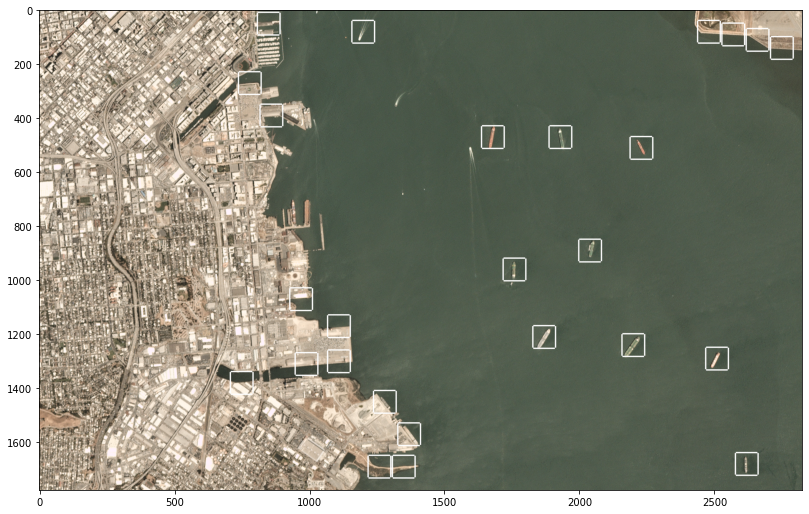

In [0]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picTensor)

plt.show()